In [51]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
#from scipy.io import netcdf
import xarray as xr
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import re
import warnings
warnings.filterwarnings("ignore")


In [53]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 
#from shapely.geometry import Point
#import geopandas as gpd
#from geopandas import GeoDataFrame
#import xarray as xr
#import netCDF4 as nc
#from netCDF4 import Dataset
#import xlrd
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        new_columns.append(pd.to_datetime(col).date())
    return new_columns

In [ ]:
# import daily_temp to extract corrsponding dates
daily_temp = pd.read_csv("dataset/temperature/daily_temp.csv").set_index("proj_id")
daily_temp.columns= convert_col_to_date(daily_temp.columns)
print(daily_temp.shape)
daily_temp.head()

In [ ]:
# dates in which the prec should be extracted
dates = daily_temp.columns
years =[i for i in range(1995,2013)]
print(f"number of total dates {len(dates)}")
# split the dates per year, to save one nc file for each year, to avoid size problem
dates_per_year ={}
for year in years:
    dates_per_year[str(year)]=[day for day in dates if day.year==year]


In [ ]:
# compute the real long/lat for each point of the grid of an ascii file
# x:long , y:lat
xdelta = 1.0 * (1./60.)
ydelta = 1.0 * (1./120.)

# compute the real long/lat for each point of the grid
long =[( 6. - 10.*xdelta) + (pt - 1)*xdelta for pt in range(0,611)]
lat =[(55. + 10.*ydelta) - (pt - 1)*ydelta for pt in range(0,971)]

In [ ]:
# create nc file for each year and store the prec values
#dims are the long/lat and the dates, the layers(variables) prec values on each day(assci file)
print(datetime.now())
print("##################")
for year in years:
    t1=datetime.now()
    print(t1)

    
    root_grp = Dataset(f'dataset/regnie_dwd/nc/{year}.nc', 'w', format='NETCDF4')
    root_grp.description = 'dims are the long/lat and the dates,(variables) prec values on each day'

    # create dimensions
    root_grp.createDimension('time', None)
    root_grp.createDimension('x', 611)
    root_grp.createDimension('y', 971)

    # create variables
    time = root_grp.createVariable('time', 'f8', ('time',))
    x = root_grp.createVariable('x', 'f4', ('x',))
    y = root_grp.createVariable('y', 'f4', ('y',))
    #each field represents a layer of prec values on a day
    field = root_grp.createVariable('field', 'f8', ('time', 'x', 'y',))

    #upload data on th dims
    x[:] = long
    y[:] = lat
    print(f"nc {year} created")
    days= dates_per_year[str(year)]
    for i, day in enumerate(days):
        
        file_name = "ra"+"".join(str(day).split("-"))[2:]

        # open an ascii file
        f = open(f'dataset/regnie_dwd/data/unzip/{file_name}', 'r')
        # extract the lines
        lines=[]
        for line in f:
            lines.append(repr(line))

        # the grid is 611x971 (west/east - northsouth)(long-lat)(x,y)
        # intialize the grid
        grid = np.zeros((971,611))
        #extract the prec values and add them to the grid
        for l, line in enumerate(lines[:-1]):# last line ignored because it is related to the time-date
            int_line = [int(l) if int(l)<999 else 999 for l in  re.sub(' +','-',line)[2:-3].replace("--","-").split("-")]
            grid[l,:(len(int_line))]= int_line

        grid =pd.DataFrame(grid)
        # add the grid as alyaer in the nc
        time[i]=i
        field[i,:,:]=grid.T
    print(f'{i} days of {year} are done')
    root_grp.close()
    t2=datetime.now()
    print(t2)
    print(t2-t1)
    print(" ")

print("##############")
print(datetime.now())

#### time for creating all nc files: 1:21:39 h

In [ ]:
# import the location of bgr_stations
bgr_loc = pd.read_csv("dataset/meta_data/bgr_location.csv").set_index("proj_id")
bgr_loc = bgr_loc[bgr_loc.columns[:2]]
print(bgr_loc.shape)
bgr_loc.head()

In [ ]:
# intialize the daily_prec df
# 1995 computed in advance 
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/daily_prec.csv").set_index("proj_id")
daily_prec

In [ ]:
# compute prec at each bgr station


def compute_prec(row):
    # return an series of all prec at one bgr long/lat over time dim in the nc file (365/364 days)
    bgr = row["bgr_long"], row["bgr_lat"]
    prec_year_list.append(ds.field.sel(x=bgr[0], y=bgr[1] ,  method='nearest').values)


# open the nc file as dataset
t3 =datetime.now()
print(t3)
print("#############")
for year in years[1:]:
    
    t1 = datetime.now()
    print(t1)
    print(f"year: {year}")
    # open nc
    ds = xr.open_dataset(f'dataset/regnie_dwd/nc/{str(year)}.nc')
    prec_year_list =[]
    #extrac prec
    bgr_loc.apply(lambda row:compute_prec(row), axis=1)
    prec_year = pd.DataFrame(prec_year_list)
    prec_year.index = bgr_loc.index
    prec_year.columns = dates_per_year[str(year)]
    # join the new year to the previous df
    # save the daily_prec in an csv
    prec_year.to_csv(f"dataset/regnie_dwd/csv/{year}.csv")
    #daily_prec = pd.concat([daily_prec,prec_year], axis=1)
    
    t2 = datetime.now()
    print(t2)
    print(t2-t1)
    print(f"{year} added")

print("#############")
t4 =datetime.now()
print(t4)
print(f"total time: {t4-t3}")

### time to compute all daily preec and save them in csv is 7:51:52 h

In [ ]:
# merge all dfs in one daily_prec
years =[i for i in range(1995,2013)]
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/1995.csv").set_index("proj_id")
for year in years[1:]:
    df=pd.read_csv(f"dataset/regnie_dwd/csv/{year}.csv").set_index("proj_id")
    daily_prec = pd.concat([daily_prec,df],axis=1)
    print(f"{year} done")
print(daily_prec.shape)
daily_prec.head()
# save the daily_prec df
#daily_prec.to_csv("dataset/regnie_dwd/csv/daily_prec.csv")

### ############################################################################

## dealing with missing

In [ ]:
# import the daily_prec
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/daily_prec.csv").set_index("proj_id")
daily_prec.columns = convert_col_to_date(daily_prec.columns)
print(daily_prec.shape)
daily_prec.head()

In [ ]:
# plot a sample
bgr_serial = 2461 #freq 7
plt.figure(figsize=(20,5))
daily_prec.iloc[bgr_serial][2500:2700].plot(color='blue',grid=True)


In [ ]:
# check the missing values in the daily_prec
daily_prec["unmeasured"]=daily_prec.apply(lambda row:sum(row==999), axis=1)
daily_prec.head()

In [ ]:
# how many missing in each row
x = daily_prec["unmeasured"]
unique_x = sorted(daily_prec["unmeasured"].unique())
unique_x

In [ ]:
for n in unique_x:
    print(f" there are {n} missing, in {sum(x==n) } rows")

print("\n")
print(f"num of missing values excluding rows with a lot of missing is {sum(x[(x<100)])} points")

### drop 58 rows that have a lot of missing
### replace the rest of missing points with zero

In [ ]:
# drop row with alot of missing 58 rows
droped_rows = daily_prec[daily_prec["unmeasured"]>1000].index
daily_prec = daily_prec.drop(droped_rows)
print(daily_prec.shape)
daily_prec.head()

In [ ]:
# replace the rest of 1031 missing with zero
daily_prec=daily_prec.applymap(lambda x:0 if x==999 else x)
daily_prec.head()

In [ ]:
### drop unmeasured column
daily_prec.drop("unmeasured", axis=1, inplace=True)
# save the daily_prec df
#daily_prec.to_csv("dataset/regnie_dwd/csv/daily_prec.csv")

##   
## Compute the cumulative prec according to the freq used in temp

In [ ]:
# import the daily_prec 
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/daily_prec.csv").set_index("proj_id")
daily_prec.columns = convert_col_to_date(daily_prec.columns)
print(daily_prec.shape)
daily_prec.head()

In [ ]:
# mimport freq df
freq_level =  pd.read_csv("dataset/time_series/freq_level.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print(freq_level[freq_level["daily"]].shape)
print(freq_level[freq_level["mid_weekly"]].shape)
print(freq_level[freq_level["weekly"]].shape)
print(freq_level[freq_level["fortnight"]].shape)
print(freq_level[freq_level["low_freq"]].shape)

freq_level.head()

In [ ]:
# filter the daily_prec accoring the existing t s
prec_freq_df = pd.concat([freq_level, daily_prec], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(prec_freq_df.shape)
prec_freq_df.head()

In [ ]:
freq_level = prec_freq_df.drop(prec_freq_df.columns[5:], axis =1)
daily_prec = prec_freq_df.drop(prec_freq_df.columns[:5], axis =1)
print("freq_level: ",freq_level.shape)
print("daily_prec: ",daily_prec.shape)

In [ ]:
# save the filtered daily_prec and freq_level
#freq_level.to_csv("dataset/regnie_dwd/csv/filtered_freq.csv")
#daily_prec.to_csv("dataset/regnie_dwd/csv/filtered_daily_prec.csv")

In [3]:
# import the daily_prec to compute cum prec and save it inplace
cum_prec=pd.read_csv("dataset/regnie_dwd/csv/filtered_daily_prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
cum_prec.head()

(12326, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,5.0,118.0,2.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,7.0,5.0,22.0,0.0,22.0,116.0,6.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0


In [4]:
# import the filtered freq df
freq_level =  pd.read_csv("dataset/regnie_dwd/csv/filtered_freq.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print(freq_level[freq_level["daily"]].shape)
print(freq_level[freq_level["mid_weekly"]].shape)
print(freq_level[freq_level["weekly"]].shape)
print(freq_level[freq_level["fortnight"]].shape)
print(freq_level[freq_level["low_freq"]].shape)

freq_level.head()

(12326, 5)
 
(3028, 5)
(957, 5)
(5713, 5)
(1658, 5)
(970, 5)


,daily,mid_weekly,weekly,fortnight,low_freq
proj_id,,,,,
BB_25470023,False,False,True,False,False
BB_25470024,False,False,True,False,False
BB_25480025,False,False,True,False,False
BB_25480026,False,False,True,False,False
BB_25481088,True,False,False,False,False


In [5]:
# add a column for freq in the daily_prec
def add_freq(bgr):
    #1. get the t s name
    #2. determine freq
    #3. compute ave
    #bgr = ave_temp.index[7569]
    freq = 0
    if freq_level.loc[bgr]["daily"]:
        #print("daily")
        freq = 1
    if freq_level.loc[bgr]["mid_weekly"]:
        #print("mid_weekly")
        freq = 4
    if freq_level.loc[bgr]["weekly"]:
        #print("weekly")
        freq = 7
    if freq_level.loc[bgr]["fortnight"]:
        #print("fortnight")
        freq = 14
    if freq_level.loc[bgr]["low_freq"]:
        #print("low_freq")
        freq = 30
    return freq

cum_prec = cum_prec.reset_index()
cum_prec["freq"] = cum_prec["proj_id"].apply(lambda row:add_freq(row))#, axis=1)
cum_prec = cum_prec.set_index("proj_id")
print(cum_prec.shape)
cum_prec.head()



(12326, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0,7
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0,7
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,4.0,22.0,0.0,5.0,118.0,2.0,7
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,7.0,5.0,22.0,0.0,22.0,116.0,6.0,7
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0,1


In [13]:
# compute the cum_prec accoring to the freq level 
T1 = datetime.now()
print(T1)
def compute_cum_prec(row):
    freq = int(row[-1])
    # leep the same values in the cells before freq in each row
    result = list(row.values[:freq-1])
    # compute the sum for the rest of the cell in each row
    result.extend([row[i-freq:i].sum() for i in range(freq,len(row))])
    result.append(freq)
    #replace the daily_prec by cum_prec
    return pd.Series(result)

cum_prec = cum_prec.apply(lambda row:compute_cum_prec(row), axis=1)
T2 =datetime.now()
print(T2)
print(T2-T1)
print(cum_prec.shape)
cum_prec.head()

2020-12-21 23:19:04.805908
2020-12-22 02:10:45.255463
2:51:40.449555
(12326, 6545)


,0,1,2,3,4,5,6,7,8,9,...,6535,6536,6537,6538,6539,6540,6541,6542,6543,6544
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,20.0,26.0,15.0,37.0,37.0,42.0,158.0,157.0,7.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,22.0,29.0,18.0,40.0,40.0,62.0,177.0,178.0,7.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0,1.0


### computaion time: 2:51:40.449555 h

In [18]:
# ename the columns
columns = list(daily_prec.columns)
columns.append("freq")
cum_prec.columns=columns
print(cum_prec.shape)
cum_prec.head()

(12326, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,20.0,26.0,15.0,37.0,37.0,42.0,158.0,157.0,7.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,22.0,29.0,18.0,40.0,40.0,62.0,177.0,178.0,7.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0,1.0


In [36]:
# save cum_prec
cum_prec.to_csv("dataset/regnie_dwd/csv/cum_prec.csv")

### 
## plot some samples

In [42]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/time_series/grouped_t_s.csv")
grouped_t_s = grouped_t_s.set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
grouped_t_s.head()

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


In [14]:
# import the daily_prec to compute cum prec and save it inplace
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/filtered_daily_prec.csv").set_index("proj_id")
daily_prec.columns = convert_col_to_date(daily_prec.columns)
print(daily_prec.shape)
daily_prec.head()

(12326, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,5.0,118.0,2.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,7.0,5.0,22.0,0.0,22.0,116.0,6.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0


In [47]:
# import the daily_prec to compute cum prec and save it inplace
cum_prec=pd.read_csv("dataset/regnie_dwd/csv/cum_prec.csv").set_index("proj_id")
columns = convert_col_to_date(cum_prec.columns[:-1])
columns.append("freq")
cum_prec.columns=columns
print(cum_prec.shape)
cum_prec.head()

(12326, 6545)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,freq
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,28.0,39.0,78.0,96.0,...,18.0,24.0,32.0,20.0,41.0,41.0,58.0,165.0,165.0,7.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,20.0,26.0,15.0,37.0,37.0,42.0,158.0,157.0,7.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,22.0,29.0,18.0,40.0,40.0,62.0,177.0,178.0,7.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0,1.0


In [80]:
# range of plot
a,b = -100,-1

#bgr_serial = 1246 #freq 1
#bgr_serial =  #freq 
bgr_serial = 2146 #freq 7
#bgr_serial = 2461 #freq 7
#bgr_serial = 4689 #freq 14
#bgr_serial = 8888 #freq 30
f =cum_prec.iloc[bgr_serial][-1] 
ts_index = grouped_t_s.iloc[bgr_serial].dropna().index
# exclude the last month of the ts -> there are no temp
ts_index = ts_index[ts_index < cum_prec.iloc[bgr_serial].index[-2]]

Text(0.5, 1.0, 'daily_prec')

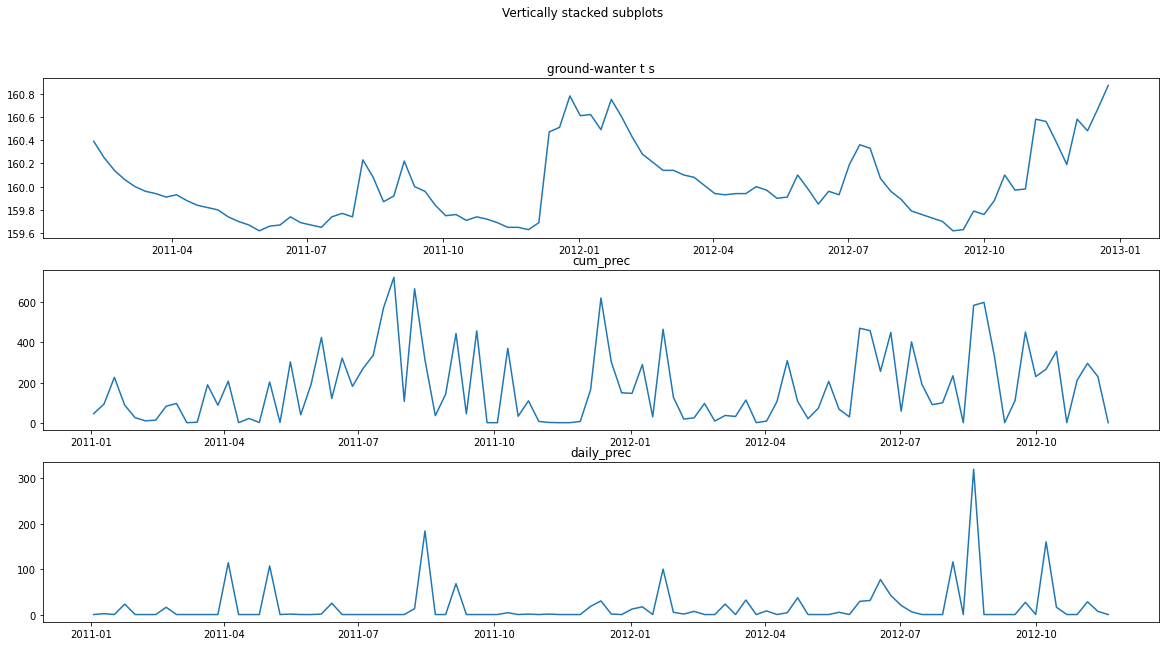

In [81]:
# the ground water t s , and cum_prec, and daily_prec

fig, axs = plt.subplots(3,1, figsize=(20,10))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(grouped_t_s.iloc[bgr_serial].dropna()[a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(cum_prec.iloc[bgr_serial][ts_index][a:b])
axs[1].set_title('cum_prec')
axs[2].plot(daily_prec.iloc[bgr_serial][ts_index][a:b])
axs[2].set_title('daily_prec')


Text(0.5, 1.0, 'daily_prec (red) vs cum_prec (blue) at a bgr station, freq=7.0')

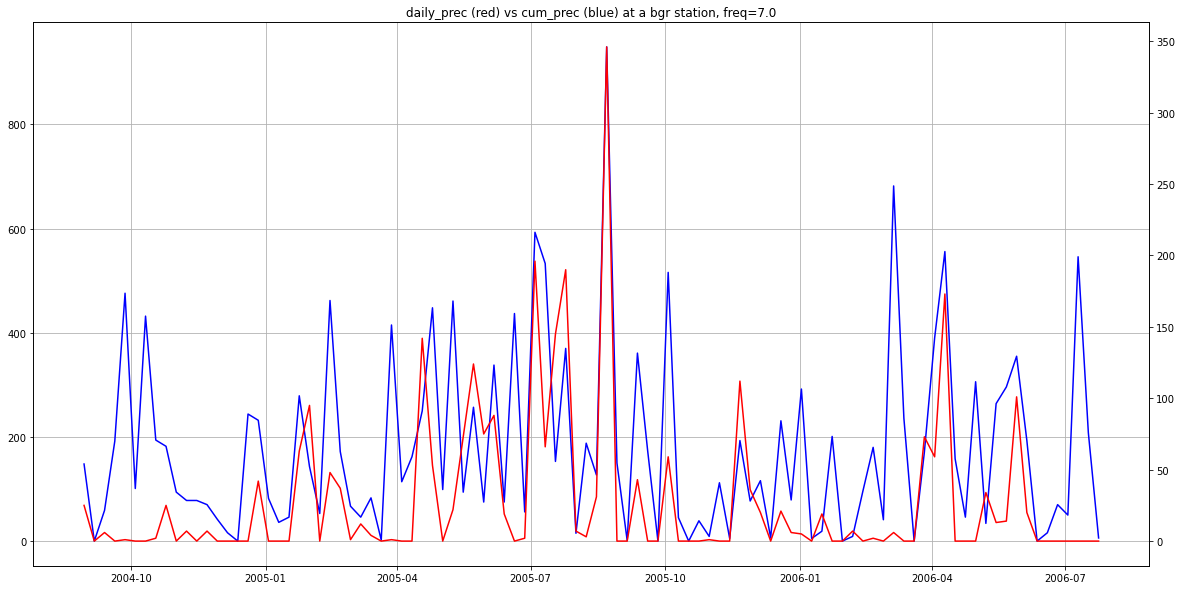

In [78]:
plt.figure(figsize=(20,10))

cum_prec.iloc[bgr_serial][ts_index][a:b].plot(color='blue',grid=True)
daily_prec.iloc[bgr_serial][ts_index][a:b].plot(color='red',grid=True, secondary_y=True)
#ave_temp.loc["BB_25481088"].dropna()[5000:5200].plot(color='red',grid=True, secondary_y=True)
plt.title(f"daily_prec (red) vs cum_prec (blue) at a bgr station, freq={f}")

# # to be used in modeling

In [ ]:
# to be used in modeling
counts, bins = np.histogram(x)
plt.hist(bins[:-1], bins, weights=counts)
